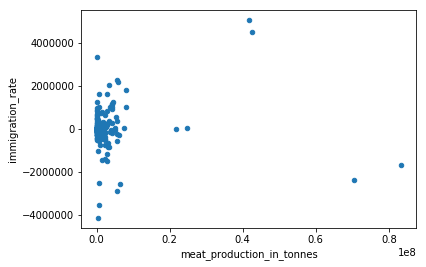

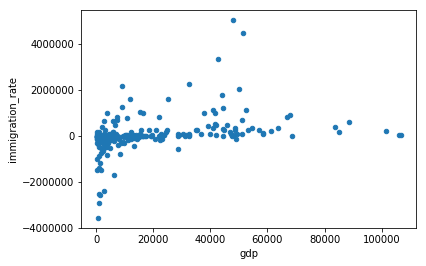

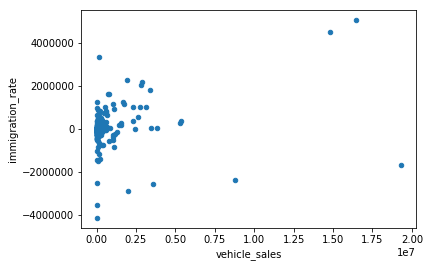

Coefficients: [-0.05215269 10.35745483  0.16478443]
Root Mean Square Error: 136143.58849440646
R^2 Score: 0.20122703607004977


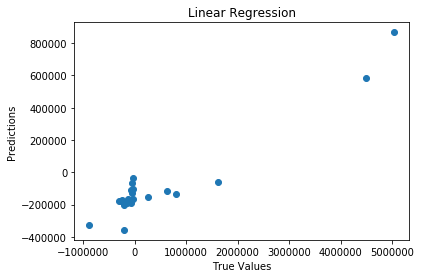

Mean of 10 fold cross validation: 0.45


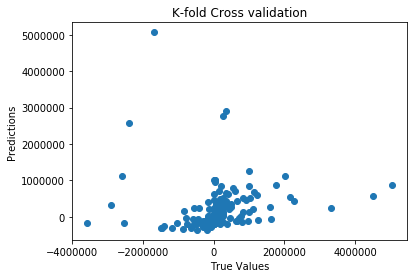

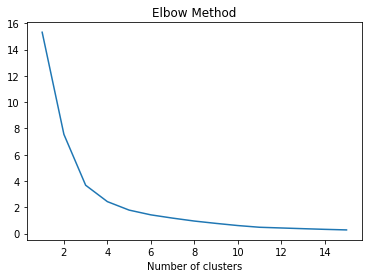

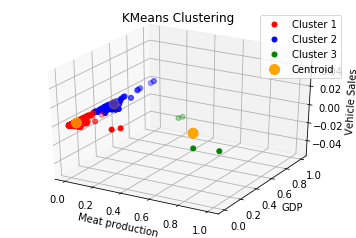

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from functools import reduce
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt

#Reading the csv data files
vehicleSales = pd.read_csv('Vehicle_Sales_Final.csv', encoding = "ISO-8859-1")
gdp = pd.read_csv('GDP_Final.csv', encoding = "ISO-8859-1")
meatProd = pd.read_csv('Meat_Production_Tonnes_Final.csv', encoding = "ISO-8859-1")
immiRate = pd.read_csv('Immigration_Rates_Final.csv', encoding = "ISO-8859-1")


#Creating a unified data frame
dfs = [immiRate, meatProd, gdp, vehicleSales]
dataSet = reduce(lambda left,right: pd.merge(left,right,on=['country','year']), dfs)


#Creating scatter plots to vizualize the data
scatter1 = dataSet.plot.scatter(3,2)
scatter2 = dataSet.plot.scatter(4,2)
scatter3 = dataSet.plot.scatter(5,2)

#removes NaN from the data
dataSet=dataSet.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

#Independent or explanatory variables
X = dataSet[['meat_production_in_tonnes','gdp','vehicle_sales']]

#The variable we are trying to predict
Y = dataSet['immigration_rate']

#Code to suggest which explantory variables to keep
lsvc = LinearSVC(C=0.01, penalty = "l1", dual=False).fit(X,Y)
modelNew = SelectFromModel(lsvc, prefit = True)
X_new = modelNew.transform(X)
# based on the code above it suggests that current explantory variables are okay

#Setting up cross validation k-folds
kf = KFold(n_splits=10) # Define the split - into 10 folds
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
KFold(n_splits=10, random_state=None, shuffle=False)

# Setting up training data and test data
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    
#Performing linear regression 
regr = linear_model.LinearRegression()
model = regr.fit(X_train, y_train)
predictions = regr.predict(X_test)
plt.show()
plt.scatter(y_test, predictions)
plt.title("Linear Regression")
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Coefficients: " + str(regr.coef_))
print("Root Mean Square Error: " + str(sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)/X_test.size)))
print("R^2 Score: " + str(model.score(X_test, y_test)))


# Perform 10-fold cross validation
scores = cross_val_score(model, X, Y, cv=10)
predictions = cross_val_predict(model, X, Y, cv=10)

plt.show()
plt.scatter(Y, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("K-fold Cross validation")
print("Mean of 10 fold cross validation: %0.2f" % abs(scores.mean()))

#Kmeans clustering
scaler = MinMaxScaler() #Scale the explantory variables

#scaling the data
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

wcss = []

for i in range (1,16): #Creating elbow method graph
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state=0) 
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    
plt.show()
plt.plot(range(1,16),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.show() # According to the elbow plot try 2 to 4 as clustering values

#KMeans clustering
kmeans = KMeans(n_clusters = 3, init = "k-means++", random_state=0)
y = kmeans.fit_predict(X_scaled)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_scaled.iloc[y == 0,0], X_scaled.iloc[y==0,1], s=25, c='red', label = 'Cluster 1')
ax.scatter(X_scaled.iloc[y == 1,0], X_scaled.iloc[y==1,1], s=25, c='blue', label = 'Cluster 2')
ax.scatter(X_scaled.iloc[y == 2,0], X_scaled.iloc[y==2,1], s=25, c='green', label = 'Cluster 3')
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='orange', label='Centroid')
plt.title('KMeans Clustering')
ax.set_xlabel('Meat production')
ax.set_ylabel('GDP')
ax.set_zlabel('Vehicle Sales')
ax.legend()

